In [1]:
!pip install pydub

In [2]:
import os
import librosa
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import librosa.display
from pydub import AudioSegment
import matplotlib.pyplot as plt
from pydub.utils import make_chunks
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [11]:
from google.colab import files

uploaded = files.upload()

Saving scaler.pkl to scaler.pkl


In [7]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model5.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/Emotion_Voice_Detection_Model5.h5")
print("Loaded model from disk")

Loaded model from disk


In [13]:
import pickle 
pkl_file = open('encoder.pkl', 'rb')
encoder = pickle.load(pkl_file)
pkl_file1 = open('scaler.pkl', 'rb')
scaler = pickle.load(pkl_file1)

In [14]:
myaudio = AudioSegment.from_file("/content/un1.mp3","mp3") 
chunk_length_ms = 4000
chunks = make_chunks(myaudio, chunk_length_ms) 
if not os.path.exists('chunks'):
    os.makedirs('chunks')
for i, chunk in enumerate(chunks):
    chunk_name = "chunk{0}".format(i)
    wav_filename = './chunks/' + chunk_name + '.wav'
    chunk.export(wav_filename, format="wav")

In [15]:
pathAudio="./chunks"
files = librosa.util.find_files(pathAudio, ext=['wav']) 
files = np.asarray(files)
data_path= pd.DataFrame(files,columns=['wav_file'])

In [16]:
def extract_features(data):
    result = np.array([])
    mfcc = np.mean(librosa.feature.mfcc(y=data).T, axis=0)
    result = np.hstack((result, mfcc))
    mel = np.mean(librosa.feature.melspectrogram(y=data).T, axis=0)
    result = np.hstack((result, mel))
    return result
def get_features(path):
    data, sample_rate = librosa.load(path)
    res1 = extract_features(data)
    result = np.array(res1)
    return result


In [17]:
X = []
for path in data_path.wav_file:
  feature = get_features(path)
  X.append(feature)

In [18]:
Cols = pd.DataFrame(X)
x1 = Cols.iloc[: ,:].values
x2 = scaler.transform(x1)
x3 = np.expand_dims(x2, axis=2)
livepreds=loaded_model.predict(x3)
livepreds1=livepreds.argmax(axis=1)
liveabc = livepreds1.astype(int).flatten()
livepredictions = (encoder.inverse_transform((liveabc)))
livepredictions

array(['exc', 'exc', 'exc', 'ang', 'exc', 'ang', 'ang', 'ang', 'ang',
       'exc', 'exc', 'ang', 'ang', 'exc', 'exc', 'exc', 'exc', 'ang',
       'exc', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang',
       'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'exc'],
      dtype=object)

In [ ]:
#Approach1
Cols = pd.DataFrame(X)
x1 = Cols.iloc[: ,:].values
x2 = scaler.transform(x1)
x3 = np.expand_dims(x2, axis=2)
livepreds=loaded_model.predict(x3)
livepreds1=livepreds.argmax(axis=1)
liveabc = livepreds1.astype(int).flatten()
b = (encoder.inverse_transform((liveabc)))
sat = []
notsat = []
for i in range(0,len(b)):
  if b[i]=='exc' or b[i]=='hap' or b[i]=='neu':
    if i <= len(b)-3:
      sat.append([b[i],10])
    elif i == len(b)-1:
      sat.append([b[i],30])
    else:
      sat.append([b[i],20])
  else:
    if i <= len(b)-3:
      notsat.append([b[i],10])
    elif i == len(b)-1:
      notsat.append([b[i],30])
    else:
      notsat.append([b[i],20])

satsum = 0
for i in range(0,len(sat)):
  satsum = sat[i][1]+satsum
print(satsum)

notsatsum = 0
for i in range(0,len(notsat)):
  notsatsum = notsat[i][1]+notsatsum
print(notsatsum)

if satsum > notsatsum:
  print("Customer was Satisfied")
elif satsum == notsatsum:
  if b[-1]=='ang' or b[-1]=='fru' or b[-1]=='sad':
    print("Customer was not satisfied")
  else:
    print("Customer was Satisfied")
else:
  print("Customer was not Satisfied")


130
260
Customer was not Satisfied


In [ ]:
data=pd.read_excel("Approach1.xlsx")
data

,file,Actual,Predicted
0,un2,unsatisfied,unsatisfied
1,un3,unsatisfied,satisfied
2,un4,unsatisfied,unsatisfied
3,un6,unsatisfied,satisfied
4,un7,unsatisfied,unsatisfied
5,un8,unsatisfied,unsatisfied
6,un1,unsatisfied,unsatisfied
7,satisfied1,satisfied,satisfied
8,satisfied2,satisfied,satisfied
9,satisfied3,satisfied,satisfied


In [ ]:
y_pred = data['Predicted']
y_test = data['Actual']
print("Approach 1")
print(classification_report(y_test, y_pred))

Approach 1
              precision    recall  f1-score   support

   satisfied       0.71      1.00      0.83        10
 unsatisfied       1.00      0.60      0.75        10

    accuracy                           0.80        20
   macro avg       0.86      0.80      0.79        20
weighted avg       0.86      0.80      0.79        20



[[10  0]
 [ 4  6]]


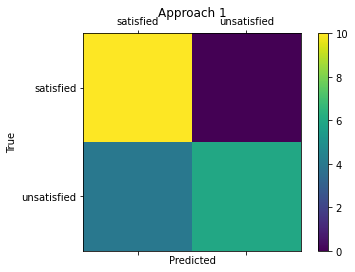

In [ ]:
from sklearn.metrics import confusion_matrix

labels = ['satisfied', 'unsatisfied']
cm = confusion_matrix(y_test, y_pred, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Approach 1')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
#Approach2
Cols = pd.DataFrame(X)
x1 = Cols.iloc[: ,:].values
x2 = scaler.transform(x1)
x3 = np.expand_dims(x2, axis=2)
satisfied= []
notsatisfied = []
for i in loaded_model.predict(x3):
  if np.argmax(i)==0 or np.argmax(i)==2 or np.argmax(i)==5:
    notsatisfied.append(max(i))
  else:
    satisfied.append(max(i))
if not satisfied:
  satisfiedmean = 0
else:
  satisfiedmean=statistics.mean(satisfied)
if not notsatisfied:
  notsatisfiedmean = 0
else:
  notsatisfiedmean=statistics.mean(notsatisfied)
if satisfiedmean > notsatisfiedmean:
  print("Customer was satisfied")
else:
  print("Customer was not satisfied")



Customer was not satisfied


In [ ]:
data1=pd.read_excel("Approach2.xlsx")
data1

,file,Actual,Predicted
0,un2,unsatisfied,unsatisfied
1,un3,unsatisfied,satisfied
2,un4,unsatisfied,unsatisfied
3,un6,unsatisfied,unsatisfied
4,un7,unsatisfied,unsatisfied
5,un8,unsatisfied,unsatisfied
6,un1,unsatisfied,unsatisfied
7,satisfied1,satisfied,satisfied
8,satisfied2,satisfied,satisfied
9,satisfied3,satisfied,satisfied


In [ ]:
y_pred = data1['Predicted']
y_test = data1['Actual']
print("Approach 2")
print(classification_report(y_test, y_pred))

Approach 2
              precision    recall  f1-score   support

   satisfied       0.73      0.80      0.76        10
 unsatisfied       0.78      0.70      0.74        10

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.75      0.75      0.75        20



[[8 2]
 [3 7]]


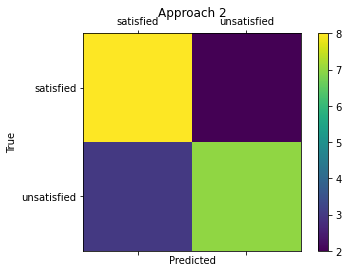

In [ ]:
from sklearn.metrics import confusion_matrix

labels = ['satisfied', 'unsatisfied']
cm = confusion_matrix(y_test, y_pred, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Approach 2')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()